In [1]:
# -*- coding: utf-PotentialUtil8 -*-PotentialUtil

In [ ]:
참고='https://ichi.pro/ko/bbn-beijian-sinnyeom-neteuwokeu-paisseon-eulo-hyogwajeog-eulo-guchughaneun-bangbeob-118195675683770'

In [2]:
!pip install PyBBN

  Created wheel for PyBBN: filename=pybbn-3.2.1-py3-none-any.whl size=39729 sha256=b11db92c7258a99fad6ba8ef3d9c45015b8edb8282fde93d763f36b3d6796699
  Stored in directory: c:\users\jihyun\appdata\local\pip\cache\wheels\06\80\2f\0e63fe5497b2917af3b7bdcbb142985ba4e5e5ef9a2c0b14b9
Successfully built PyBBN


In [1]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [2]:
df=pd.read_csv('./Data/해양경찰청_해상조난사고_상세데이터_현황_20191231.csv', encoding='euckr')
df.rename(columns={'선 종':'선종'},inplace=True)
df = df[['발생일시','관할해경서','발생해역','기상상태','발생원인','발생유형','선종']]
df = df.drop_duplicates()
df['사고월']=df['발생일시'].apply(lambda x: 'January' if x.split('-')[1]=='01' \
                                    else 'February' if x.split('-')[1]=='02'
                                    else 'March' if x.split('-')[1]=='03'\
                                    else 'April' if x.split('-')[1]=='04'\
                                    else 'May' if x.split('-')[1]=='05'\
                                    else 'June' if x.split('-')[1]=='06'\
                                    else 'July' if x.split('-')[1]=='07'\
                                    else 'August' if x.split('-')[1]=='08'\
                                    else 'September' if x.split('-')[1]=='09'\
                                    else 'October' if x.split('-')[1]=='10'\
                                    else 'November' if x.split('-')[1]=='11'\
                                    else 'December' if x.split('-')[1]=='12'\
                                    else 'etc'
                           )

In [3]:
df

,발생일시,관할해경서,발생해역,기상상태,발생원인,발생유형,선종,사고월
0,2019-12-31 22:04,포항,영해,양호,관리소홀,기타,모터보트,December
1,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,어선,December
2,2019-12-31 15:13,포항,영해,양호,운항부주의,충돌,화물선,December
3,2019-12-31 9:33,통영,협수로,양호,운항부주의,부유물감김,어선,December
4,2019-12-31 8:38,군산,항계 내,양호,관리소홀,침수,어선,December
...,...,...,...,...,...,...,...,...
3815,2019-01-01 14:08,인천,영해,양호,운항부주의,부유물감김,모터보트,January
3816,2019-01-01 9:14,인천,협수로,양호,운항부주의,침수,어선,January
3817,2019-01-01 7:59,완도,항계 내,양호,운항부주의,좌초/좌주,모터보트,January
3818,2019-01-01 3:31,태안,영해,양호,운항부주의,침몰,기타,January


### 확률

In [60]:
def get_conditional_prob(df, child, parent1=None, parent2=None):
    p_list=[]
    if parent1==None:
        #print('no parent')
        
        child_values = df[child].unique()

        idx = df[child].value_counts(normalize=True).index
        p = df[child].value_counts(normalize=True).values
        p_list += [[i,j] for i,j in zip(idx,p)]
        for childv in child_values:
            if childv not in idx:
                p_list += [childv,0]


    elif (parent1!=None) and (parent2==None):
        #print('parent1')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()

        for par1 in parent1_values:
            idx = df[df[parent1]==par1][child].value_counts(normalize=True, sort=True).sort_index().index
            p = df[df[parent1]==par1][child].value_counts(normalize=True, sort=True).sort_index().values
            p_list += [[par1,childv,p] for childv,p in zip(idx,p)]
            for childv in child_values:
                if childv not in idx:
                    p_list += [[par1, childv, 0]]
            idx_list = [i[1] for i in p_list]
            
            #parent_value별 조건부확률 누적 값은 1이 되어야 함
            #print(sum(p))

    elif (parent1!=None) and (parent2!=None):  
        #print('parent2')
        
        child_values = df[child].unique()
        parent1_values = df[parent1].unique()
        parent2_values = df[parent2].unique()

        for par1 in parent1_values:
            for par2 in parent2_values:
                #0일땐 안나오나봄... -> 이건어쩌지 
                idx = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True, sort=True).sort_index().index
                p = df[(df[parent1]==par1) & (df[parent2]==par2)][child].value_counts(normalize=True, sort=True).sort_index().values
                p_list += [[par1,par2,childv,p] for childv,p in zip(idx,p)]

                for childv in child_values:
                    if childv not in idx:
                        p_list += [[par1, par2, childv,0]]
                #parent_value별 조건부확률 누적 값은 1이 되어야 함
                #해당 case가 하나도 없으면 0
                #print(sum(p))
    
    return idx_list, p_list

    
    

In [57]:
weather_p = get_conditional_prob(df,'기상상태')
month_p = get_conditional_prob(df,'사고월', parent1='기상상태')
ocean_p = get_conditional_prob(df,'발생해역', parent1='기상상태')
jurisdiction_p = get_conditional_prob(df,'관할해경서', parent1='발생해역')
vessel_type_p = get_conditional_prob(df,'선종', parent1='발생해역')
cause_p = get_conditional_prob(df,'발생원인', parent1='발생해역')
accident_type_p = get_conditional_prob(df,'발생유형', parent1='발생원인')

In [24]:
weather_idx = [i[0] for i in weather_p]
weather_p = [i[-1] for i in weather_p]

month_idx = [i[1] for i in month_p]
month_p = [i[-1] for i in month_p]

ocean_idx = [i[1] for i in ocean_p]
ocean_p = [i[-1] for i in ocean_p]

jurisdiction_idx = [i[1] for i in jurisdiction_p]
jurisdiction_p = [i[-1] for i in jurisdiction_p]

vessel_type_idx = [i[1] for i in vessel_type_p]
vessel_type_p = [i[-1] for i in vessel_type_p]

cause_idx = [i[1] for i in cause_p]
cause_p = [i[-1] for i in cause_p]

accident_type_idx = [i[1] for i in accident_type_p]
accident_type_p = [i[-1] for i in accident_type_p]

In [62]:
month_idx, month_p = get_conditional_prob(df,'사고월', parent1='기상상태')
month_idx

['April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'April',
 'August',
 'December',
 'February',
 'January',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'July',
 'April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'April',
 'February',
 'January',
 'July',
 'May',
 'November',
 'October',
 'December',
 'August',
 'September',
 'June',
 'March',
 'November',
 'October',
 'September',
 'December',
 'April',
 'August',
 'May',
 'July',
 'June',
 'March',
 'February',
 'January',
 'April',
 'August',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'December',
 'July',
 'October',
 'September',
 'December',
 'April',
 'No

### 베이지안네트워크 구축

#### 노드

In [35]:
weather = BbnNode(Variable(0, 'weather', weather_idx, weather_p)

month = BbnNode(Variable(1, 'month', month_idx), month_p)

ocean = BbnNode(Variable(1, 'ocean', ocean_idx, ocean_p)

jurisdiction = BbnNode(Variable(2, 'jurisdiction', jurisdiction_idx, jurisdiction_p)

cause = BbnNode(Variable(3, 'cause', cause_idx, cause_p)

ship = BbnNode(Variable(4, 'ship', df['선종'].unique().tolist()), probs(df, child='선종', parent1='발생해역'))

accident_type = BbnNode(Variable(5, 'accident_type', df['발생유형'].unique().tolist()), probs(df, child='발생유형', parent1='발생원인'))

SyntaxError: invalid syntax (<ipython-input-35-f868eae4ff88>, line 3)

In [36]:
month_idx

['August',
 'September',
 'October',
 'July',
 'May',
 'June',
 'November',
 'April',
 'January',
 'December',
 'March',
 'February',
 'November',
 'April',
 'February',
 'October',
 'March',
 'May',
 'January',
 'December',
 'July',
 'August',
 'June',
 'September',
 'February',
 'April',
 'August',
 'January',
 'October',
 'November',
 'March',
 'May',
 'June',
 'September',
 'December',
 'July',
 'October',
 'May',
 'February',
 'June',
 'March',
 'December',
 'November',
 'September',
 'August',
 'January',
 'April',
 'July',
 'January',
 'February',
 'April',
 'October',
 'November',
 'July',
 'May',
 'December',
 'August',
 'September',
 'June',
 'March',
 'September',
 'November',
 'October',
 'December',
 'April',
 'August',
 'May',
 'July',
 'June',
 'March',
 'February',
 'January',
 'July',
 'March',
 'August',
 'June',
 'April',
 'September',
 'May',
 'October',
 'January',
 'February',
 'November',
 'December',
 'September',
 'July',
 'October',
 'December',
 'April',
 'No

In [ ]:
weather = BbnNode(Variable(0, 'weather', weather_idx, weather_p)

#month = BbnNode(Variable(1, 'month', month_idx, month_p)

ocean = BbnNode(Variable(2, 'ocean', ocean_idx, ocean_p)

jurisdiction = BbnNode(Variable(3, 'jurisdiction', jurisdiction_idx, jurisdiction_p)

cause = BbnNode(Variable(4, 'cause', cause_idx, cause_p)

vessel_type = BbnNode(Variable(5, 'vessel_type', vessel_type_idx, vessel_type_p)

accident_type = BbnNode(Variable(6, 'accident_type', accident_type_idx, accident_type_p)

In [90]:
df['기상상태'].value_counts(normalize=True, sort=False).sort_index()

양호       0.886126
저시정      0.030105
태풍경보     0.022513
태풍주의보    0.001832
풍랑경보     0.002356
풍랑주의보    0.025131
황천4급     0.004450
황천5급     0.015445
황천6급     0.012042
Name: 기상상태, dtype: float64

In [89]:
a = df['기상상태'].value_counts(sort=False).sort_index().tolist()
b = sum(a)
c = [i/b for i in a]
c

[0.8861256544502618,
 0.030104712041884817,
 0.022513089005235604,
 0.0018324607329842932,
 0.002356020942408377,
 0.025130890052356022,
 0.004450261780104712,
 0.015445026178010472,
 0.012041884816753926]

####  엣지

In [74]:
bbn = Bbn().add_node(weather)\
    .add_node(ocean)\
    .add_node(jurisdiction)\
    .add_node(cause)\
    .add_node(ship)\
    .add_node(accident_type)\
    .add_edge(Edge(weather, ocean, EdgeType.DIRECTED))\
    .add_edge(Edge(ocean, jurisdiction, EdgeType.DIRECTED))\
    .add_edge(Edge(ocean, cause, EdgeType.DIRECTED))\
    .add_edge(Edge(ocean, ship, EdgeType.DIRECTED))\
    .add_edge(Edge(cause, accident_type, EdgeType.DIRECTED))

In [75]:
join_tree = InferenceController.apply(bbn)

IndexError: list index out of range

In [72]:
for node in bbn.get_nodes():
    parents = [bbn.get_node(parent_id) for parent_id in bbn.get_parents_ordered(node.id)]
    #potential = PotentialUtil.get_potential(node, parents)
    print(node)

0|weather|양호,풍랑주의보,황천5급,황천6급,황천4급,풍랑경보,저시정,태풍경보,태풍주의보
1|ocean|영해,협수로,항계 내,영해-EEZ,공해,EEZ-30마일 이내
2|jurisdiction|포항,통영,군산,여수,서귀포,인천,보령,동해,부산,울진,목포,속초,완도,제주,평택,창원,울산,태안,부안
3|cause|관리소홀,운항부주의,정비불량,안전부주의,화기취급부주의,연료고갈,기타 ,기상악화,기상악화(인명은 기타),적재불량,재질불량
4|ship|모터보트,어선,화물선,기타,낚시어선,유조선,예부선,여객선,관공선,요트,고무보트,유도선,기타(통선)
5|accident_type|기타,충돌,부유물감김,침수,침몰,해양오염,화재,작업 중 인명사상,기관손상,추진기손상,좌초/좌주,키손상,운항저해,접촉,전복,침수(인명은기타),방향상실,폭발,시설물손상,속구손상


In [73]:
!which python

'which'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


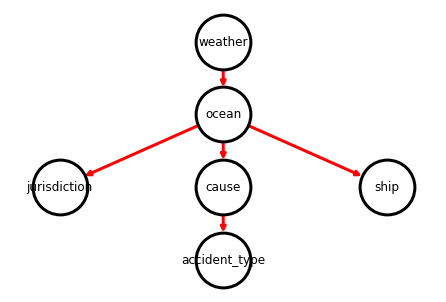

In [77]:
# Set node positions
pos = {0: (0, 2), 1: (0, 1), 2: (-1, 0), 3: (0, 0), 4: (1, 0), 5: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 12,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 3,
    "width": 3,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.show()

In [61]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

NameError: name 'join_tree' is not defined